# **Thyroid Ultrasound Image Classification for Disease Diagnosis**

# Step 1 : Install Required Libraries

In [ ]:
!pip install kaggle
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install scikit-learn
!pip install imagehash
!pip install Pillow
!pip install transformers huggingface_hub

# Step 2 : Import and Set Up

In [2]:
from huggingface_hub import HfApi, HfFolder
import os
from google.colab import userdata

# ดึง token จาก Google Colab secrets
HF_TOKEN = userdata.get('HF_TOKEN')

# บันทึก token ลงใน HfFolder
HfFolder.save_token(HF_TOKEN)

# ตรวจสอบว่า token ถูกตั้งค่าเรียบร้อยแล้ว
print("Token saved to HfFolder:", HF_TOKEN is not None)

# สร้าง api object เพื่อใช้งาน
api = HfApi()

Token saved to HfFolder: True


In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download azouzmaroua/algeria-ultrasound-images-thyroid-dataset-auitd --force
!unzip algeria-ultrasound-images-thyroid-dataset-auitd.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 3 : Prepare data for training
From local file to pandas dataframe

In [7]:
import kaggle
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Image, Dataset
from transformers import AutoImageProcessor, DefaultDataCollator, AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback, pipeline
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomResizedCrop, Resize, ToTensor, RandomHorizontalFlip
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import imagehash
import matplotlib.pyplot as plt
import shutil

In [8]:
benign_folder = '/content/dataset thyroid/train/Benign'

# ตรวจสอบว่าโฟลเดอร์มีอยู่หรือไม่
if os.path.exists(benign_folder):
    # ลบไฟล์ทั้งหมดในโฟลเดอร์
    for filename in os.listdir(benign_folder):
        file_path = os.path.join(benign_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    os.makedirs(benign_folder)

In [9]:
# Path to the shared folder on Google Drive
source_folder = '/content/drive/MyDrive/Benign'  # แก้ไขเป็นชื่อโฟลเดอร์ที่ถูกต้อง

# Destination folder
destination_folder = '/content/dataset thyroid/train/Benign'

# ตรวจสอบว่าโฟลเดอร์เป้าหมายมีอยู่หรือไม่
os.makedirs(destination_folder, exist_ok=True)

# คัดลอกไฟล์ทั้งหมดจากโฟลเดอร์ต้นทางไปยังโฟลเดอร์ปลายทาง
for item in os.listdir(source_folder):
    s = os.path.join(source_folder, item)
    d = os.path.join(destination_folder, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, False, None)
    else:
        shutil.copy2(s, d)

In [10]:
def remove_duplicates(image_paths):
    unique_images = {}
    duplicates = []

    for image_path in image_paths:
        try:
            with Image.open(image_path) as img:
                img_hash = hashlib.md5(img.tobytes()).hexdigest()

                if img_hash in unique_images:
                    duplicates.append(image_path)
                else:
                    unique_images[img_hash] = image_path
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # ลบไฟล์ที่ซ้ำกัน
    for duplicate in duplicates:
        os.remove(duplicate)
        print(f"Removed duplicate image: {duplicate}")

    return list(unique_images.values())

In [ ]:
seed_num = 112233

# โหลดชุดข้อมูล
data_root_path = "/content/dataset thyroid/"
data_split = os.listdir(data_root_path)

df_total = pd.DataFrame()
for split in data_split:
  data_path = os.path.join(data_root_path, split)
  class_list = os.listdir(data_path)

  for class_name in class_list:
    data_temp_pd = pd.DataFrame()
    file_path = os.path.join(data_path, class_name)
    file_list = os.listdir(file_path)
    file_list = [file_name for file_name in file_list if file_name.endswith(".jpg")]
    full_file_path = [os.path.join(file_path,file_name) for file_name in file_list]

    data_temp_pd['id'] = file_list
    data_temp_pd['image'] = full_file_path
    data_temp_pd['label'] = class_name

    df_total = pd.concat([df_total, data_temp_pd])

remove_duplicates(df_total['image'].tolist())
df_total['label'] = df_total['label'].str.lower()

In [ ]:
df_total

,id,image,label
0,4A_23.jpg,/content/dataset thyroid/test/Malignant/4A_23.jpg,malignant
1,4C_6.jpg,/content/dataset thyroid/test/Malignant/4C_6.jpg,malignant
2,4B_5.jpg,/content/dataset thyroid/test/Malignant/4B_5.jpg,malignant
3,4A_88.jpg,/content/dataset thyroid/test/Malignant/4A_88.jpg,malignant
4,4C_59.jpg,/content/dataset thyroid/test/Malignant/4C_59.jpg,malignant
...,...,...,...
287,2_20 - Copy (2).jpg,/content/dataset thyroid/train/benign/2_20 - C...,benign
288,3_9.jpg,/content/dataset thyroid/train/benign/3_9.jpg,benign
289,2_35.jpg,/content/dataset thyroid/train/benign/2_35.jpg,benign
290,2_28.jpg,/content/dataset thyroid/train/benign/2_28.jpg,benign


In [12]:
id2label = df_total[['label']].drop_duplicates().reset_index(drop = True)['label'].to_dict()
label2id  = {key:value for value, key in id2label.items()}
df_total['label'] = df_total['label'].map(label2id)

df_train, df_test = train_test_split(df_total, test_size=0.05, random_state=seed_num, stratify= df_total['label'])

In [ ]:
id2label

{0: 'malignant', 1: 'benign', 2: 'normal thyroid'}

In [ ]:
label2id

{'malignant': 0, 'benign': 1, 'normal thyroid': 2}

In [13]:
df_train['label'].value_counts()

label
0    866
1    555
2    162
Name: count, dtype: int64

In [14]:
df_test['label'].value_counts()

label
0    46
1    29
2     9
Name: count, dtype: int64

In [15]:
print(f"Train set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Train set size: 1583
Test set size: 84


In [ ]:
dataset_train = Dataset.from_dict(df_train)
dataset_train = dataset_train.cast_column("image", Image())

dataset_test = Dataset.from_dict(df_test)
dataset_test = dataset_test.cast_column("image", Image())

# Model ViT

In [ ]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None

elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose([RandomResizedCrop(size), RandomHorizontalFlip(), ToTensor(), normalize])
val_transforms = Compose([Resize(size), CenterCrop(crop_size),ToTensor(), normalize])

def transforms_train(examples):
    examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    return examples

def transforms_validate(examples):
    examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]]
    return examples

dataset_train = dataset_train.with_transform(transforms_train)
dataset_test = dataset_test.with_transform(transforms_validate)

# Metric F1 Score

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, predictions, average='weighted',zero_division=0)
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(label2id.keys()),
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir = "./",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate= 6e-5,            # Main value for fine tuning
    per_device_train_batch_size=32,# Main value for fine tuning
    gradient_accumulation_steps=1, # Main value for fine tuning
    per_device_eval_batch_size=32, # Main value for fine tuning
    num_train_epochs= 30,           # Main value for fine tuning, starting from low number !!
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=True,
    hub_model_id="agent593/Thyroid-Ultrasound-Image-Classification-ViTModel"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # เพิ่ม EarlyStoppingCallback
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Step 4 : Training

In [ ]:
train_results = trainer.train()
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.842600,0.770172,0.642857,0.602899,0.642857,0.595728
2,0.632900,0.654415,0.738095,0.659090,0.738095,0.696122
3,0.576200,0.569246,0.666667,0.619296,0.666667,0.620677
4,0.561300,0.545730,0.761905,0.810603,0.761905,0.758153
5,0.515700,0.476253,0.761905,0.798454,0.761905,0.755468
6,0.410600,0.382488,0.833333,0.861243,0.833333,0.832559
7,0.482400,0.249050,0.916667,0.913264,0.916667,0.911559
8,0.387600,0.254309,0.892857,0.899550,0.892857,0.893022
9,0.336200,0.198914,0.928571,0.932019,0.928571,0.928912
10,0.411000,0.245391,0.916667,0.923968,0.916667,0.916634


{'eval_loss': 0.12298397719860077, 'eval_accuracy': 0.9642857142857143, 'eval_precision': 0.9664723032069971, 'eval_recall': 0.9642857142857143, 'eval_f1': 0.9632571010860486, 'eval_runtime': 1.3086, 'eval_samples_per_second': 64.19, 'eval_steps_per_second': 2.292, 'epoch': 16.0}


# History log

In [ ]:
pd.DataFrame(trainer.state.log_history)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1320,1.752978,0.000002,0.1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.1268,1.747214,0.000004,0.2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0957,1.411546,0.000006,0.3,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0543,1.661708,0.000008,0.4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0079,1.300003,0.000010,0.5,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.3144,4.838485,0.000031,15.9,795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,0.2250,0.347200,0.000031,16.0,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,NaN,NaN,NaN,16.0,800,0.173610,0.940476,0.942772,0.940476,0.937622,1.5123,55.544,1.984,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,16.0,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1599.7428,29.686,0.938,1.962735e+18,0.434353


In [ ]:
pd.DataFrame(trainer.state.log_history).head(21)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1320,1.752978,0.000002,0.1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.1268,1.747214,0.000004,0.2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0957,1.411546,0.000006,0.3,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0543,1.661708,0.000008,0.4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0079,1.300003,0.000010,0.5,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.9749,1.231757,0.000012,0.6,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.9142,1.690668,0.000014,0.7,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.8893,1.268396,0.000016,0.8,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.8080,1.235340,0.000018,0.9,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.8426,2.141244,0.000020,1.0,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Pipeline

In [ ]:
classifier = pipeline("image-classification", model="agent593/Thyroid-Ultrasound-Image-Classification-ViTModel")

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

In [ ]:
image = "/content/dataset thyroid/test/Malignant/4A_0.jpg"
classifier(image)

[{'label': 'malignant', 'score': 0.953050434589386},
 {'label': 'benign', 'score': 0.03293987363576889},
 {'label': 'normal thyroid', 'score': 0.014009721577167511}]

In [ ]:
image = "/content/dataset thyroid/test/normal thyroid/tiroides (37).jpg"
classifier(image)

[{'label': 'normal thyroid', 'score': 0.9672436118125916},
 {'label': 'malignant', 'score': 0.018764222040772438},
 {'label': 'benign', 'score': 0.013992165215313435}]

# Confusion Matrix

In [ ]:
def predict_with_threshold(model, dataloader, threshold):
    model.eval()
    predictions, labels = [], []

    for batch in dataloader:
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        batch_predictions = (probs > threshold).astype(int)
        batch_labels = batch["labels"].cpu().numpy()

        predictions.extend(batch_predictions)
        labels.extend(batch_labels)

    return np.array(predictions), np.array(labels)

def plot_confusion_matrix(predictions, labels, class_names, title):
    cm = confusion_matrix(labels, np.argmax(predictions, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

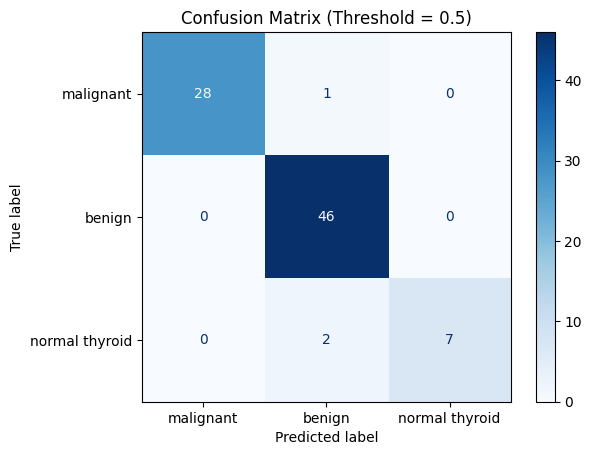

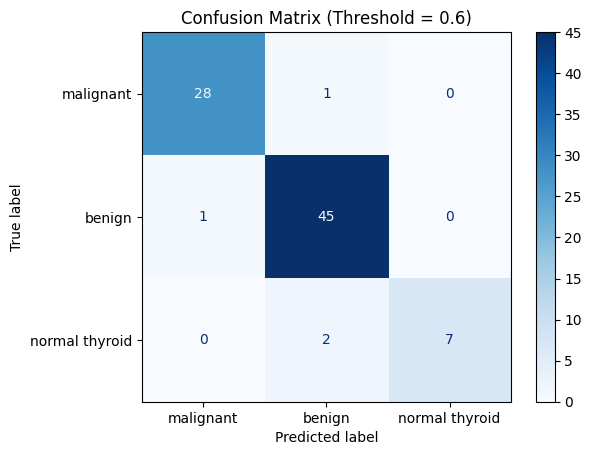

In [ ]:
# สร้างคำทำนายสำหรับ threshold 0.5
predictions_05, labels = predict_with_threshold(trainer.model, trainer.get_eval_dataloader(dataset_test), threshold=0.5)

# สร้างคำทำนายสำหรับ threshold 0.6
predictions_06, _ = predict_with_threshold(trainer.model, trainer.get_eval_dataloader(dataset_test), threshold=0.6)

# กำหนดชื่อคลาส
class_names = [v for k, v in id2label.items()]

# สร้างและแสดงผล Confusion Matrix สำหรับ threshold 0.5
plot_confusion_matrix(predictions_05, labels, class_names, "Confusion Matrix (Threshold = 0.5)")

# สร้างและแสดงผล Confusion Matrix สำหรับ threshold 0.6
plot_confusion_matrix(predictions_06, labels, class_names, "Confusion Matrix (Threshold = 0.6)")